# Modeling 

In [5]:
import os, sys
sys.path.append(os.path.abspath('../.'))

In [7]:
import random
import pickle
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modeling import baseline_modeling, class_names
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

## Setting dataframes
- df_baseline is just numerical data
- just metadata dataframe (in the works)
- df_text is with vectorized description
    - this was already split into train and test sets to preprocess
    - going to be joined to df after splitting into train/test

In [10]:
# load in dataframe
df = pd.read_csv('../data/9_1_all_books_df.csv')

# this just includes pages and ratings along with the target of best seller or not
df_baseline = df[['rating', 'pages', 'best_seller']]

# this data is already split into the training set with a reset index
# so it will be concated with the df after spliting into train and test sets
df_text_X = pd.read_csv('../data/X_train_nlp.csv')
df_text_y= pd.read_csv('../data/y_train_nlp.csv', header=None)
df_text_X_test = pd.read_csv('../data/X_test_nlp.csv')
df_text_y_test = pd.read_csv('../data/y_test_nlp.csv', header=None)

# target names is in modeling.py
# split the dataset into training and validation datasets for just numerical data
X_train_rating, X_test_rating, y_train_rating, y_test_rating = train_test_split(df_baseline[['rating', 'pages']], 
                                                                    df_baseline['best_seller'], 
                                                                    test_size = .2,
                                                                   random_state=42)

df_text = df_text_X 
df_text['_target'] = df_text_y[0]
# deep vs shallow copies
df_text_X = df_text_X.loc[:, df_text_X.columns != '_target']

# Tree based Modeling

## Numerical Random Forest

In [11]:
rf = RandomForestClassifier(random_state=42)

{'clf score': 0.982695810564663, 'clf confusion': array([[868,   3],
        [ 16, 211]])}

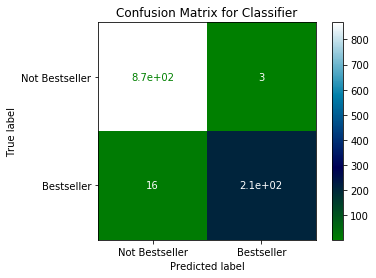

In [12]:
baseline_modeling(rf, X_train_rating, y_train_rating)

{'clf score': 0.982695810564663, 'clf confusion': array([[868,   3],
        [ 16, 211]])}

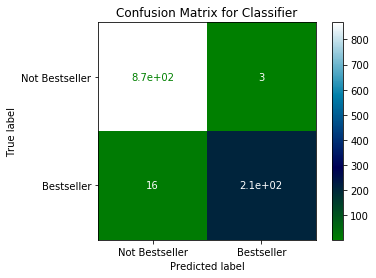

In [13]:
baseline_modeling(rf, X_train_rating, y_train_rating)

In [6]:
# random_forest.decision_path(X_train_rating)

In [7]:
# random_forest.decision_path(X_test_rating)

In [8]:
# random_forest.feature_importances_

## Text Modeling Random Forest

In [14]:
rf_text = RandomForestClassifier(random_state=42)

{'clf score': 0.98816029143898, 'clf confusion': array([[869,   2],
        [ 11, 216]])}

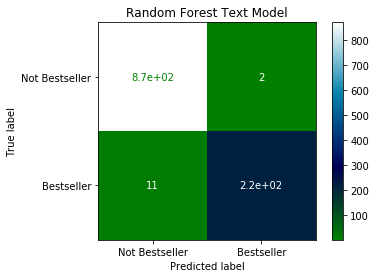

In [15]:
baseline_modeling(rf_text, df_text_X, df_text_y[0], confusion_title='Random Forest Text Model')


In [16]:
rf_text.score(df_text_X, df_text_y[0])

0.98816029143898

# Logistic Regression

## Numerical Logistic

In [17]:
log  = LogisticRegression(random_state=42)

{'clf score': 0.807832422586521, 'clf confusion': array([[862,   9],
        [202,  25]])}

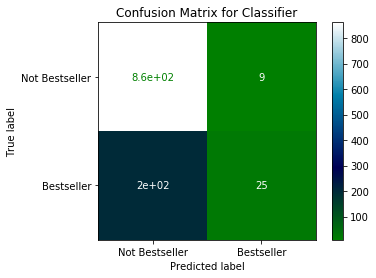

In [18]:
baseline_modeling(log, X_train_rating, y_train_rating)

In [19]:
log_cv = LogisticRegressionCV(cv = 5, random_state=42)

{'clf score': 0.8060109289617486, 'clf confusion': array([[860,  11],
        [202,  25]])}

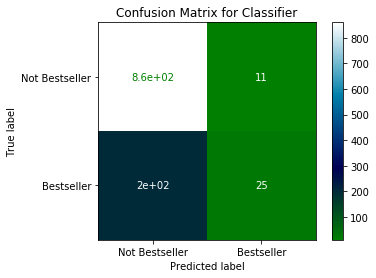

In [20]:
baseline_modeling(log_cv, X_train_rating, y_train_rating)

## Text Modeling Logistic 

In [21]:
log_text = LogisticRegression(random_state=42)

{'clf score': 0.9653916211293261, 'clf confusion': array([[871,   0],
        [ 38, 189]])}

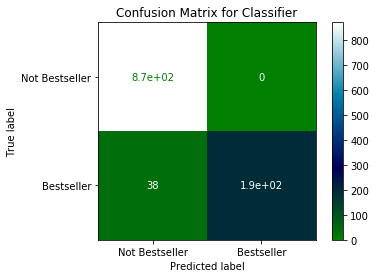

In [22]:
baseline_modeling(log_text, df_text_X, df_text_y[0] )

In [23]:
# max iterations needed to be 100 -> 400 for text modeling
log_text_cv = LogisticRegressionCV(cv = 5, max_iter=400, random_state=42)

{'clf score': 0.9389799635701275, 'clf confusion': array([[871,   0],
        [ 67, 160]])}

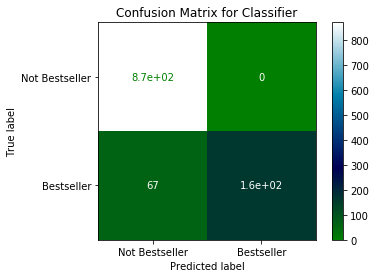

In [24]:
baseline_modeling(log_text_cv, df_text_X, df_text_y[0] )

the cross validated logistic fit the training data slightly less.

# optimization

## Logistic Regression

In [20]:
# only use penalty_e with 'saga'
penalty_e = 'elasticnet'
solver_e = 'saga'

#  'newton-cg', 'lbfgs', ‘sag’ and ‘saga’ handle L2 or no penalty
# ‘liblinear’ solver supports both L1 and L2 regularization
#  ‘elasticnet’ penalty is only supported by the ‘saga’ solver.
penalty_l1_l2 = ['l1', 'l2']
solvers_l1_l2 = ['saga', 'linlinear']

# 'newton-cg' , 'lbfgs' , 'sag' , also not using 'saga'
# using penalty_l2, these solvers can't use 'l1'
penalty_l2 = ['l2', 'none']
solvers_l2 = ['newton-cg', 'lbfgs', 'sag' ]

# range of values for C
C = np.logspace(-4, 4, 50)
# {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [21]:
# hyperparameter space to iterate over
distributions_l1_l2 = dict(C = np.logspace(-4, 4, 50),
                    penalty = penalty_l1_l2,
                    solver = solvers_l1_l2)

distributions_l2 = dict(C = np.logspace(-4, 4, 50),
                    penalty = penalty_l2,
                    solver = solvers_l2)

In [22]:
log_opt = LogisticRegression(random_state=42)

log_ran = RandomizedSearchCV(log_opt, distributions_l1_l2, random_state=42)

search = log_ran.fit(X_train_rating, y_train_rating)

search.best_params_

{'solver': 'saga', 'penalty': 'l2', 'C': 0.0013894954943731374}

In [23]:
search.score(X_train_rating, y_train_rating)

0.7932604735883424

In [24]:
log_opt_l2 = LogisticRegression(random_state=42)
log_ran_l2 = RandomizedSearchCV(log_opt_l2, distributions_l2, random_state=42)
search_l2 = log_ran_l2.fit(X_train_rating, y_train_rating)

In [25]:
search_l2.best_params_

{'solver': 'newton-cg', 'penalty': 'none', 'C': 0.00014563484775012445}

In [26]:
search_l2.score(X_train_rating, y_train_rating)

0.8060109289617486

In [27]:
log_cv.score(X_train_rating, y_train_rating)

0.8060109289617486

### grid search

In [28]:
log_grid_opt = LogisticRegression(random_state=42)
log_grid_params = {'penalty':('l1', 'l2'), 'solver':('saga', 'linlinear'), 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_grid = GridSearchCV(log_grid_opt, log_grid_params)
log_grid.fit(X_train_rating, y_train_rating)
# sorted(rf_grid.cv_results_.keys())

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ('l1', 'l2'),
                         'solver': ('saga', 'linlinear')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
log_grid.best_params_

{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}

In [30]:
log_grid.score(X_train_rating, y_train_rating)

0.7932604735883424

## random forest

### random search

In [31]:
# n_estimators -> number of trees in the forest default is 100
n_estimators = list(range(100, 500, 20))
# max_features
max_features_rf = ['auto', 'sqrt', 'log2']
criterion_rf = ['gini', 'entropy']

# hyperparameter space to iterate over
distributions_rf = dict(n_estimators = list(range(100, 500, 20)),
                    max_features = max_features_rf,
                    criterion = criterion_rf)

In [57]:
rf_opt = RandomForestClassifier(random_state=42)

rf_ran = RandomizedSearchCV(rf_opt, distributions_rf, random_state=42)

search_rf = rf_ran.fit(X_train_rating, y_train_rating)

search_rf.best_params_

{'n_estimators': 100, 'max_features': 'log2', 'criterion': 'gini'}

In [58]:
search_rf.score(X_train_rating, y_train_rating)

0.982695810564663

In [35]:
search_rf.score(X_test_rating, y_test_rating)

0.7709090909090909

In [64]:
rf_text_opt = RandomForestClassifier(random_state=42)

rf_text_ran = RandomizedSearchCV(rf_text_opt, distributions_rf, random_state=42)

search_text_rf = rf_text_ran.fit(df_text_X, df_text_y[0])

search_text_rf.best_params_

{'n_estimators': 240, 'max_features': 'log2', 'criterion': 'entropy'}

In [36]:
confusion_matrix(df_y_test, log_text_test_preds)

### grid search

In [37]:
rf_grid_opt = RandomForestClassifier(random_state=42)
rf_grid_params = {'max_features':('auto', 'sqrt', 'log2'), 'n_estimators':[100, 200, 400], 'criterion':('gini', 'entropy')}
rf_grid = GridSearchCV(rf_grid_opt, rf_grid_params)
rf_grid.fit(X_train_rating, y_train_rating)
# sorted(rf_grid.cv_results_.keys())

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                               

In [38]:
rf_grid.score(X_train_rating, y_train_rating)

0.982695810564663

In [39]:
rf_grid.score(X_test_rating, y_test_rating)

0.7709090909090909

In [40]:
rf_grid.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}

# testing data

### random forest

0.7709090909090909

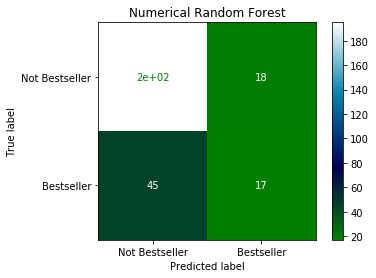

In [41]:
# rf on testing data
# baseline_modeling(rf, X_train_rating, y_train_rating)
rf_test_preds = rf.predict(X_test_rating)
rf_confusion = confusion_matrix(y_test_rating, rf_test_preds)
rf_plot_confusion = plot_confusion_matrix(rf, X_test_rating, y_test_rating, cmap='ocean', 
                                          display_labels=class_names).ax_.set_title('Numerical Random Forest')
rf_score = rf.score(X_test_rating, y_test_rating)
rf_score

0.8109090909090909

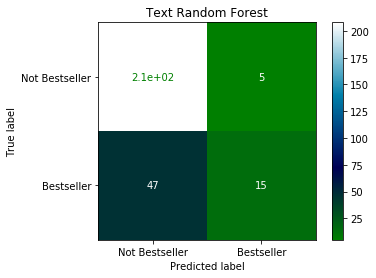

In [42]:
# rf_text on testing data
# baseline_modeling(rf, X_train_rating, y_train_rating)
rf_text_test_preds = rf_text.predict(df_text_X_test)
rf_text_confusion = confusion_matrix(df_text_y_test, rf_text_test_preds)
rf_text_plot_confusion = plot_confusion_matrix(rf_text, df_text_X_test, df_text_y_test, cmap='ocean', 
                                          display_labels=class_names).ax_.set_title('Text Random Forest')
rf_text_score = rf_text.score(df_text_X_test, df_text_y_test)
rf_text_score

0.7709090909090909

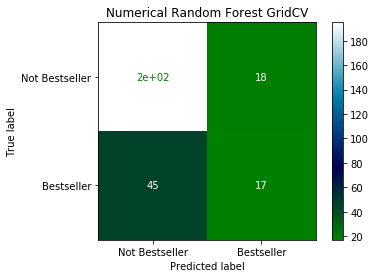

In [55]:
# rf_grid
# rf_text on testing data
# baseline_modeling(rf, X_train_rating, y_train_rating)
rf_grid_test_preds = rf_grid.predict(X_test_rating)
rf_grid_confusion = confusion_matrix(y_test_rating, rf_grid_test_preds)
rf_grid_plot_confusion = plot_confusion_matrix(rf_grid, X_test_rating, y_test_rating, cmap='ocean', 
                                          display_labels=class_names) .ax_.set_title('Numerical Random Forest GridCV')
rf_grid_score = rf_grid.score(X_test_rating, y_test_rating)
rf_grid_score

0.7709090909090909

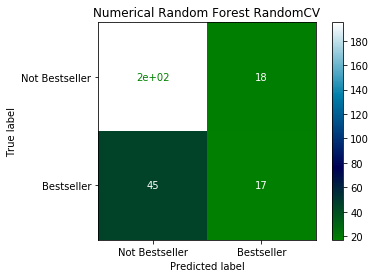

In [60]:
# search_rf
# rf_text on testing data
# baseline_modeling(rf, X_train_rating, y_train_rating)
search_rf_test_preds = search_rf.predict(X_test_rating)
search_rf_confusion = confusion_matrix(y_test_rating, search_rf_test_preds)
search_rf_plot_confusion = plot_confusion_matrix(search_rf, X_test_rating, y_test_rating, cmap='ocean', 
                                          display_labels=class_names) .ax_.set_title('Numerical Random Forest RandomCV')
search_rf_score = search_rf.score(X_test_rating, y_test_rating)
search_rf_score

0.8109090909090909

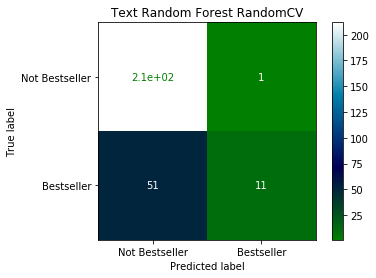

In [67]:
# search_text_rf
# df_text_X_test
# df_text_y_test
# baseline_modeling(rf, X_train_rating, y_train_rating)
search_text_rf_test_preds = search_text_rf.predict(df_text_X_test)
search_text_rf_confusion = confusion_matrix(df_text_y_test, search_text_rf_test_preds)
search_text_rf_plot_confusion = plot_confusion_matrix(search_text_rf, df_text_X_test, df_text_y_test, cmap='ocean', 
                                          display_labels=class_names) .ax_.set_title('Text Random Forest RandomCV')
search_text_rf_score = search_text_rf.score(df_text_X_test, df_text_y_test)
search_text_rf_score

### logistic regression

0.7927272727272727

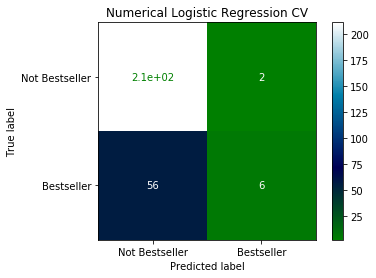

In [44]:
# log on testing data
# baseline_modeling(rf, X_train_rating, y_train_rating)
log_cv_test_preds = log_cv.predict(X_test_rating)
log_cv_confusion = confusion_matrix(y_test_rating, log_cv_test_preds)
log_cv_plot_confusion = plot_confusion_matrix(log_cv, X_test_rating, y_test_rating, cmap='ocean',
                                           display_labels=class_names).ax_.set_title('Numerical Logistic Regression CV')
log_cv_score = log.score(X_test_rating, y_test_rating)
log_cv_score

# Save top model
- check randomized search
- save the rf_text model

In [25]:
rf_text

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [49]:
rf_text_pickle = 'models/rf_text_model.sav'
# pickle.dump(rf_text, open(rf_text_pickle, 'wb'))

In [50]:
rf_text_pickle

'models/rf_text_model.sav'

In [51]:
rf_text

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [71]:
search_text_rf.best_params_

{'n_estimators': 240, 'max_features': 'log2', 'criterion': 'entropy'}

In [68]:
search_text_rf

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [61]:
search_rf

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [53]:
rf_grid

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                               

In [52]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# TODO

- feature importance 
    - random forest

In [37]:
importances = rf_text.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_text.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [38]:
indices

array([4021,  518, 4091, ..., 2276, 1213, 5841])

In [ ]:
# map most important features
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_text_X.shape[1]), 
        importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(df_text_X.shape[1]), indices[:9])
plt.xlim([-1, df_text_X.shape[1]])
plt.show()